In [334]:
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [74]:
df_climbs_angles = pd.read_csv('data/csvs/climbs_with_angles.csv', low_memory=False)
df_climbs = pd.read_csv('data/csvs/climbs.csv')
df_holes = pd.read_csv('data/csvs/holes.csv')
df_colors = pd.read_csv('data/csvs/placement_roles.csv')
df_vscale = pd.read_csv('data/csvs/vscale.csv')

kilter_xlim = 144
kilter_ylim = 156

def extract_hold_data(frame_str):
    color_strings = re.findall(r'\d+', frame_str)
    return [int(color_str) for color_str in color_strings]

def get_coordinates(id_list, df_holes, normalize=False):
    coordinates = []
    for id_val in id_list:
        coords = df_holes[df_holes['id'] == id_val][['x', 'y']].values.tolist()
        if normalize: 
            if coords != []:
                coords[0][0] /= kilter_xlim
                coords[0][1] /= kilter_ylim
        coordinates.extend(coords)
    return coordinates

In [75]:
# Load in the JSON file
with open("data/jsons/specific_landmarks_sequence.json", "r") as file:
    vid_lm = json.load(file)
    
with open("data/jsons/holds.json", "r") as file:
    vid_lm_holds = json.load(file)


In [76]:
df_climbs['ids'] = df_climbs['frames'].apply(lambda x: extract_hold_data(x)[0::2])
df_climbs['normalized_coordinates'] = df_climbs['ids'].apply(lambda x: get_coordinates(x, df_holes, normalize=True))
df_climbs['colors'] = df_climbs['frames'].apply(lambda x: extract_hold_data(x)[1::2])

# get static positions of the holds 

In [150]:
df = pd.DataFrame(vid_lm)

left_wrist = df.iloc[:, 0].apply(lambda x: [x['x'], abs(1-x['y'])])
right_wrist = df.iloc[:, 1].apply(lambda x: [x['x'], abs(1-x['y'])])
left_ankle = df.iloc[:, 2].apply(lambda x: [x['x'], abs(1-x['y'])])
right_ankle = df.iloc[:, 3].apply(lambda x: [x['x'], abs(1-x['y'])])

In [78]:
color_mapping = df_colors.set_index('id')['full_name'].to_dict()

df_climbs['hold_type'] = df_climbs.colors.apply(
    lambda x: [
        color_mapping.get(color) 
        if color else None
        for color in x
    ]
)

kilter_holds = {}
for counter, i in enumerate(df_climbs.hold_type[1]):
    if i in kilter_holds.keys():
        kilter_holds[i].append(df_climbs.normalized_coordinates[1][counter])
    else:
        kilter_holds[i] = [df_climbs.normalized_coordinates[1][counter]]

In [410]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

def perform_clustering_and_plot(hold_dict, n_clusters_dict, kilter_holds, eps=0.05, min_samples=2):
    colors = {'Start': '#00DD00', 'Middle': '#00FFFF', 'Finish': '#FF00FF'}
    cluster_centers_dict = {}
    
    plt.figure(figsize=(10, 6))
    
    for hold_type, coords in hold_dict.items():
        coords_array = np.array(coords)
        coords_array[:, 1] = 1 - coords_array[:, 1]  # Flip Y-axis
        n_clusters = n_clusters_dict.get(hold_type, 1)
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(coords_array)
        non_outliers = labels != -1
        
        # Use only non_outliers if they exist, otherwise use all points
        coords_to_use = non_outliers if np.sum(non_outliers) > 0 else None
        kmeans = KMeans(n_clusters=n_clusters, n_init=100, max_iter=1000, random_state=42)
        clusters = kmeans.fit_predict(coords_array[coords_to_use]) if coords_to_use is not None else kmeans.fit_predict(coords_array)
        cluster_centers = kmeans.cluster_centers_
        
        # Update cluster_centers_dict and plot
        cluster_centers_dict[hold_type] = cluster_centers
        plt.scatter(coords_array[:, 0], coords_array[:, 1], c=colors.get(hold_type, 'k'), label=hold_type, alpha=1, edgecolors='w')
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c=colors.get(hold_type, 'k'), s=300, alpha=1, marker='o')

    # Matching Predicted and Real Hold Positions
    assignments = {}
    cluster_centers = {key: val[:, :2] for key, val in cluster_centers_dict.items()}
    
    for category, points1 in cluster_centers.items():
        points2 = np.array(kilter_holds[category])
        
        # Compute distance matrix and find optimal assignment
        cost_matrix = cdist(points1, points2)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignments[category] = (row_ind, col_ind)
        
        # Plotting
        plt.scatter(points2[:, 0], points2[:, 1], c=colors.get(category, 'k'), s=100, label=f'{category} Real', marker='o', edgecolors='w')
        
        for point1, point2 in zip(row_ind, col_ind):
            dx = points2[point2, 0] - points1[point1, 0]
            dy = points2[point2, 1] - points1[point1, 1]
            plt.arrow(points1[point1, 0], points1[point1, 1], dx, dy, 
                    shape='full', color='k', length_includes_head=True, 
                    head_width=0.02, linewidth=0.3, alpha=0.7)

    plt.title('Clustering and Matching of Hold Positions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    
    return cluster_centers_dict, assignments


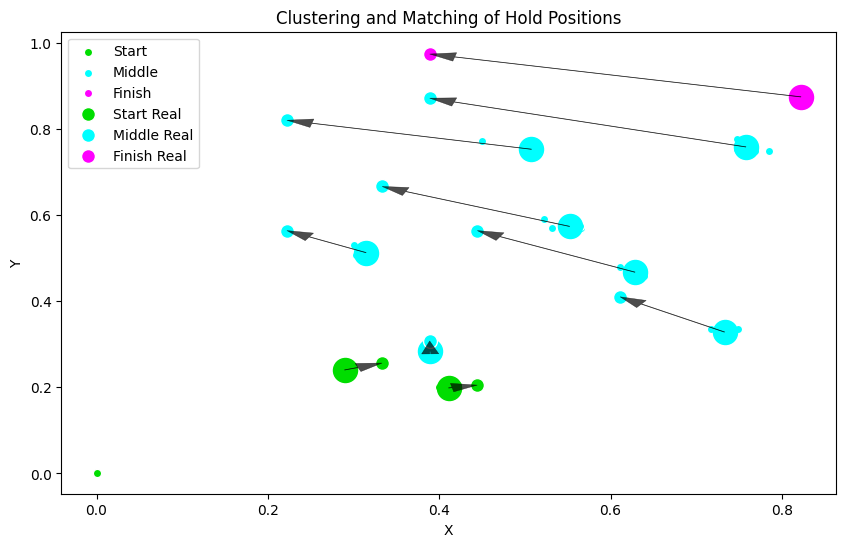

In [411]:
n_clusters_dict = {'Start': len(kilter_holds['Start']), 'Middle': len(kilter_holds['Middle']), 'Finish': len(kilter_holds['Finish'])}
cluster_centers = perform_clustering_and_plot(vid_lm_holds, n_clusters_dict, kilter_holds)

In [401]:
def plot_given_positions(hold_dict):
    colors = {'Start': 'g', 'Middle': 'b', 'Finish': 'r', 'Foot Only': 'orange'}
    
    plt.figure(figsize=(10, 6))
    
    for hold_type, coords in hold_dict.items():
        coords_array = np.array(coords)
        
        # Plotting
        plt.scatter(coords_array[:, 0], coords_array[:, 1], 
                    c=colors.get(hold_type, 'k'), label=hold_type, alpha=0.6, edgecolors='w')
        
    plt.title('Hold Positions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

In [337]:
def plot_matched_points(cluster_centers, kilter_holds):
    """
    Plot matched points between predicted and real hold positions with a professional appearance.
    
    Parameters:
        cluster_centers (dict): Predicted cluster center coordinates.
        kilter_holds (dict): Real hold positions.
    """
    plt.figure(figsize=(12, 8))
    assignments = {}
    cluster_centers = {key: val[:, :2] for key, val in cluster_centers.items()}

    # Define color for each category for better differentiation and aesthetics
    colors = {'Start': 'blue', 'Middle': 'green', 'Finish': 'purple'}
    
    for category, points1 in cluster_centers.items():
        points2 = np.array(kilter_holds[category])
        
        # Compute distance matrix and find optimal assignment
        cost_matrix = cdist(points1, points2)
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignments[category] = (row_ind, col_ind)
        
        # Define custom scatter points and line styles for better visualization
        plt.scatter(points1[:, 0], points1[:, 1], color=colors.get(category, 'black'), s=100, 
                    label=f'{category} Predicted', marker='x')
        plt.scatter(points2[:, 0], points2[:, 1], color=colors.get(category, 'black'), s=50, 
                    label=f'{category} Real', marker='o')
        
        # Add slightly transparent lines for matching points to avoid cluttering
        for point1, point2 in zip(row_ind, col_ind):
            plt.plot([points1[point1, 0], points2[point2, 0]], 
                     [points1[point1, 1], points2[point2, 1]], 
                     linestyle='--', linewidth=1.5, color=colors.get(category, 'black'), alpha=0.6)

    # Add professional-looking title, labels, and legend
    plt.title('Matching Predicted and Real Hold Positions', fontsize=16, fontweight='bold')
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.legend(loc='upper right', fontsize=12, frameon=False)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Option to save the figure as a high-res PNG
    # plt.savefig("matched_points.png", dpi=300)
    
    plt.show()


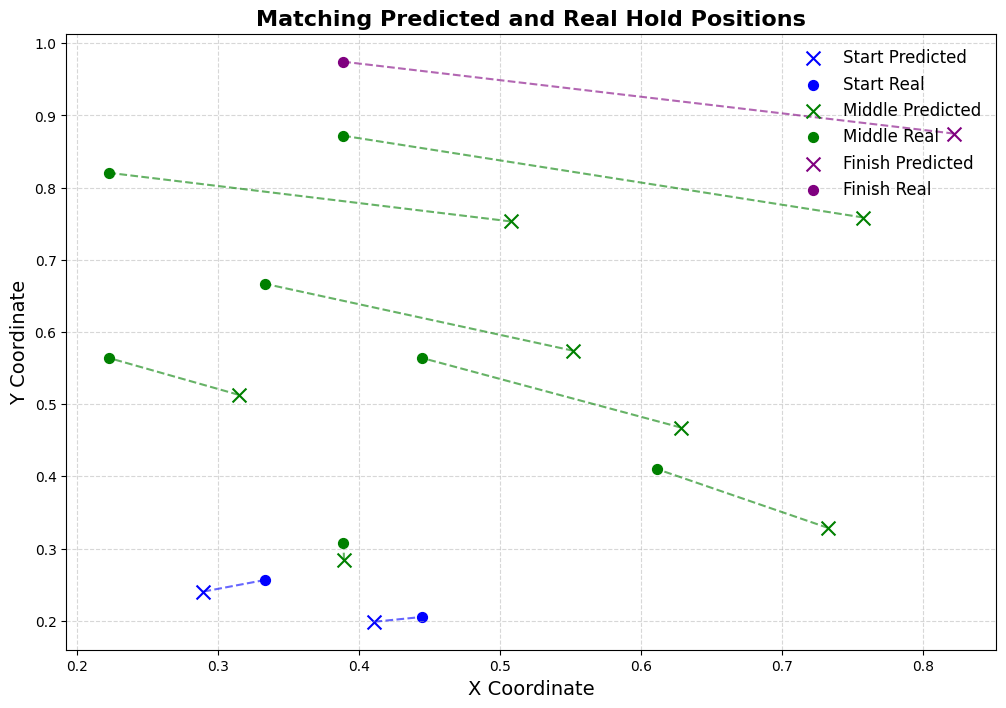

In [338]:
plot_matched_points(cluster_centers, kilter_holds)